In [13]:
import surprise
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 평점 데이터
- MovieLense라는 영화 추천 웹사이트의 데이터
- 10만개 로드

In [4]:
data = surprise.Dataset.load_builtin('ml-100k')

In [5]:
df = pd.DataFrame(data.raw_ratings, columns=["user", "item", "rate", "id"])
del df['id']
df.head()

,user,item,rate
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


- user : ID, item : 상품 ID, rate : 평점

In [6]:
df.isnull().sum()

user    0
item    0
rate    0
dtype: int64

In [7]:
df_table = df.set_index(['user', 'item']).unstack()

In [12]:
#sparse data
df_table.iloc[212:222, 808:817].fillna('')

rate                                
item  211 212 213 214 215 216 217 218 219
user                                     
290     3                   4       2    
291         4       4   4           4   4
292                 3                    
293     4       3       4   4   3   2    
294                                      
295             5       5   5   4   5    
296     4                                
297     4       3       2   4       3    
298     5       3       5                
299     4   4   5           5

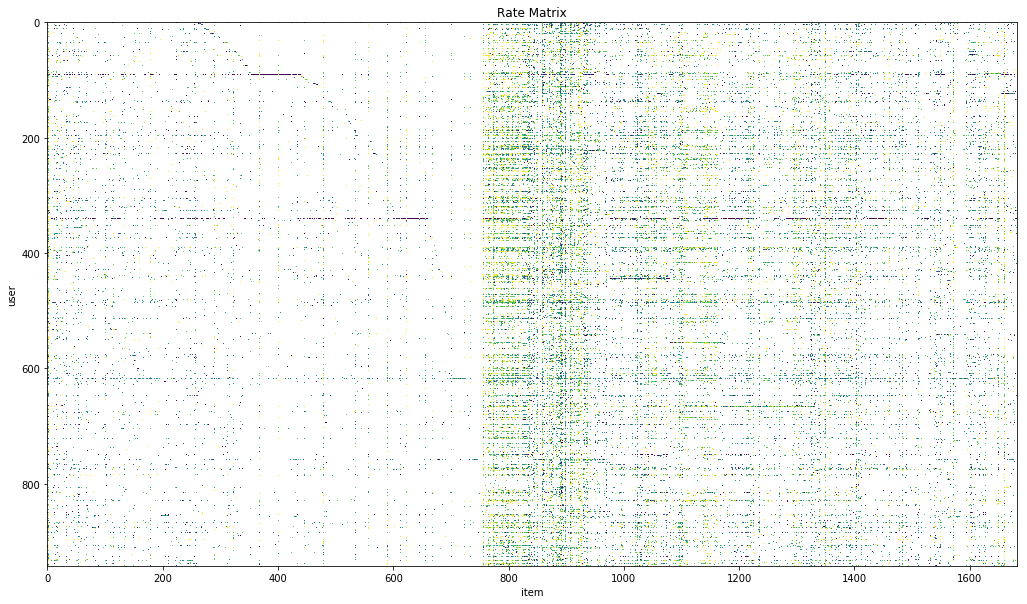

In [15]:
plt.figure(figsize = (20,10))
plt.imshow(df_table)
plt.grid(False)
plt.xlabel("item")
plt.ylabel("user")
plt.title("Rate Matrix")
plt.show()

# 평가기준
- RMSE (Root Mean Squared Error) $$\text{RMSE} = \sqrt{\frac{1}{|\hat{R}|} \sum_{\hat{r}_{ui} \in \hat{R}}(r_{ui} - \hat{r}_{ui})^2}$$
- MAE(Mean Absolute Error) $$\text{MAE} = \dfrac{1}{|\hat{R}|} \sum_{\hat{r}_{ui} \in \hat{R}}|r_{ui} - \hat{r}_{ui}|$$
- FCP (Fraction of Concordant Pairs) $$\text{FCP} = \dfrac{\text{number of concordant pairs}}{\text{number of discordant pairs}}$$

# 1.baseline 모형
- 전체 평점의 평균 + 동일한 사용자에 의한 평점 조정값 + 동일한 상품에 대한 평점 조정값
- $$\hat{r}_{ui} = \mu + b_u + b_i$$
- LSE와 같은 방법으로 최적화 $$\sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2$$
- 정규화 항 추가 $$\sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 + \lambda \left(b_u^2 + b_i^2 \right)$$

## 최적화 알고리즘
### SGD(Stochastic Gradient Descent)
- reg : 정규화 가중치.(0.02)
- learning_rate(0.005)
- n_epochs(20)
### ALS(Alternating Least Squares)
- reg_i : 상품에 대한 정규화 가중치(10)
- reg_u : 사용자에 대한 정규화 가중치(15)
- n_epochs(10)

In [18]:
bsl_options = {
    'method' : 'als', #algorithm selection
    'n_epochs' : 5,
    'reg_u': 12,
    'reg_i' : 5
}

In [19]:
algo = surprise.BaselineOnly(bsl_options)

#### 3-fold

In [23]:
from surprise.model_selection import KFold

In [24]:
np.random.seed(0)
acc = np.zeros(3)
cv = KFold(3)

for i, (trainset, testset) in enumerate(cv.split(data)) :
    algo.fit(trainset)
    predictions = algo.test(testset)
    acc[i] = surprise.accuracy.rmse(predictions, verbose=True) #testset prediction


Estimating biases using als...
RMSE: 0.9453
Estimating biases using als...
RMSE: 0.9377
Estimating biases using als...
RMSE: 0.9500


In [25]:
acc.mean()

0.9443304984013942

#### cross-validation

In [26]:
from surprise.model_selection import cross_validate
cross_validate(algo, data)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.9384446 , 0.94651657, 0.93612815, 0.94221861, 0.94428787]),
 'test_mae': array([0.74477853, 0.75124267, 0.73975393, 0.745764  , 0.74659098]),
 'fit_time': (0.11968040466308594,
  0.1376333236694336,
  0.14561176300048828,
  0.16255855560302734,
  0.13862848281860352),
 'test_time': (0.11469244956970215,
  0.21143293380737305,
  0.12666106224060059,
  0.0997323989868164,
  0.1107034683227539)}

# 2. Collaborative Filter
- 평점 행렬이 가진 특정한 패턴을 찾아서 이를 평점 예측에 사용하는 방법

#### Neighborhood 모형
- 사용자나 상품 기준으로 평점의 유사성


#### Latent Factor 모형
- 행렬의 수치적 특징 이용

# 2-1. Neighborhood 모형(Memory-based CF) : 해당 사용자와 similar 사용자에 대해 가중치를 줌
#### - User-based CF
- 평점 행렬에서 유사한 사용자 행 벡터를 찾아 이를 기반으로

#### - Item-based Cf
- 특정한 상품에 대해 사용자가 준 점수. 평점행렬에서 열 벡터를 기반으로


# Similarity 계산
### Mean Squared Difference Similarity(평균제곱차이 유사도)
- MSD(Mean Sqruared Difference)의 역수를 취해서 구한다.

##### 사용자 u와 v간의 msd 
- $$\text{msd}(u, v) = \frac{1}{|I_{uv}|} \cdot \sum\limits_{i \in I_{uv}} (r_{ui} - r_{vi})^2$$
- 위 식에서 $I_{uv}$ 는 사용자  u 와 사용자  v  모두에 의해 평가된 상품의 집합이고  $|I_{uv}|$ 는 사용자  u 와 사용자  v  모두에 의해 평가된 상품의 수
- 평가된 모든 상품에 대해 계산

##### 상품 i와 j간의 msd
- $$\text{msd}(i, j) = \frac{1}{|U_{ij}|} \cdot \sum\limits_{u \in U_{ij}} (r_{ui} - r_{uj})^2$$
- 위 식에서  $U_{ij}$ 는 상품  i 와 상품  j  모두를 평가한 사용자의 집합이고  $|U_{ij}|$ 는 상품  i 와 상품  j  모두를 평가한 사용자의 수
- 평가한 모든 사람에 대해 계산

## $$\begin{split}\text{msd_sim}(u, v) &= \frac{1}{\text{msd}(u, v) + 1}\\
\text{msd_sim}(i, j) &= \frac{1}{\text{msd}(i, j) + 1}\end{split}$$

### Cosine Similarity(코사인 유사도)
- 두 특성 벡터의 각도에 대한 코사인 값
- 각도가 0이면 유사도 1, 각도가 90이면 유사도 0

##### 사용자  u 와 사용자  v 간의 cs
$$\text{cosine_sim}(u, v) = \frac{
\sum\limits_{i \in I_{uv}} r_{ui} \cdot r_{vi}}
{\sqrt{\sum\limits_{i \in I_{uv}} r_{ui}^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} r_{vi}^2}
}$$

##### 상품  i 와 상품  j 간의 cs
$$\text{cosine_sim}(i, j) = \frac{
\sum\limits_{u \in U_{ij}} r_{ui} \cdot r_{uj}}
{\sqrt{\sum\limits_{u \in U_{ij}} r_{ui}^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} r_{uj}^2}
}$$

### Pearson Similarity(피어슨 유사도)
- 두 벡터간 상관계수
##### 사용자  u 와 사용자  v 간의 PS
$$\text{pearson_sim}(u, v) = \frac{
\sum\limits_{i \in I_{uv}} (r_{ui} -  \mu_u) \cdot (r_{vi} - \mu_{v})}
{\sqrt{\sum\limits_{i \in I_{uv}} (r_{ui} -  \mu_u)^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} (r_{vi} -  \mu_{v})^2}
}$$
- $\mu_u$ : 사용자 u 의 평균 평점
##### 상품  i 와 상품  j 간의 PS
$$\text{pearson_sim}(i, j) = \frac{
\sum\limits_{u \in U_{ij}} (r_{ui} -  \mu_i) \cdot (r_{uj} - \mu_{j})}
{\sqrt{\sum\limits_{u \in U_{ij}} (r_{ui} -  \mu_i)^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} (r_{uj} -  \mu_{j})^2}
}$$
- $\mu_i$ : 상품 i의 평균 평점

### Pearson-Baseline Similarity(피어슨-베이스라인 유사도)
- 상관계수를 구하되, 단순 평균이 아닌 베이스라인 모형에서 예측한 값 사용
##### 사용자  u 와 사용자  v 간의 PBS
$$\text{pearson_baseline_sim}(u, v) = \hat{\rho}_{uv} = \frac{
\sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui}) \cdot (r_{vi} - b_{vi})}
{\sqrt{\sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui})^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} (r_{vi} -  b_{vi})^2}}
$$
##### 상품  i 와 상품  j 간의 PBS
$$\text{pearson_baseline_sim}(i, j) = \hat{\rho}_{ij} = \frac{
\sum\limits_{u \in U_{ij}} (r_{ui} -  b_{ui}) \cdot (r_{uj} - b_{uj})}
{\sqrt{\sum\limits_{u \in U_{ij}} (r_{ui} -  b_{ui})^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} (r_{uj} -  b_{uj})^2}}
$$
- 두 사용자나 상품에 공통적으로 있는 평점 원소의 갯수를 이용하여 정규화를 하는 shrinkage를 추가하기도 한다.
$$\begin{split}\text{pearson_baseline_shrunk_sim}(u, v) &= \frac{|I_{uv}| - 1}
{|I_{uv}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{uv}\end{split}
$$
$$\begin{split}\text{pearson_baseline_shrunk_sim}(i, j) &= \frac{|U_{ij}| - 1}
{|U_{ij}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{ij}\end{split}
$$


# Similarity parameter 조정
- name : 유사도의 종류 (MSD)
- user_based : True user-based / False item-based
- min_support : 두 사용자나, 상품에서 공통적으로 있는 평점 원소의 수의 최솟값. 공통 평점 원소의 수가 이 값보다 적으면 사용하지 않음.
- shrinkage : shrinkage 가중치

## KNN 가중치 예측 방법
- 유사도를 구하고, 유사도가 큰 k개의 사용자 또는 상품 벡터를 사용하여 가중 평균을 구한다.
- $N^k$ 는 $k$개의 가장 유사도가 큰 벡터의 집합

### KNNBasic
- 평점들의 단순 평균
$$\hat{r}_{ui} = \frac{
        \sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot r_{vi}}
        {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)}
$$
$$\hat{r}_{ui} = \frac{
        \sum\limits_{j \in N^k_u(i)} \text{sim}(i, j) \cdot r_{uj}}
        {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)}
        $$
        
- 유사도가 클수록 그 평점을 많이 반영

### KNNWithMeans
- 평점들을 평균값 기준으로 가중평균
- 평균보다 작은지 큰지 반영
$$\hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - \mu_v)} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}
$$
$$\hat{r}_{ui} = \mu_i + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r_{uj} - \mu_j)} {\sum\limits_{j \in
N^k_u(i)} \text{sim}(i, j)}
$$

### KNNBaseline
- 평점들을 베이스라인 모형의 예측값 기준으로 평균
$$\hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}
$$
$$\hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in
N^k_u(j)} \text{sim}(i, j)}
$$

## MODELING

In [27]:
#MSD - best
sim_options = {'name' : 'msd'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.97650906, 0.98346442, 0.97032533, 0.98330974, 0.9818553 ]),
 'test_mae': array([0.77163701, 0.77538984, 0.7665685 , 0.77493766, 0.77486794]),
 'fit_time': (1.155592441558838,
  1.201275110244751,
  1.1870551109313965,
  1.1668522357940674,
  1.1962120532989502),
 'test_time': (7.701850414276123,
  7.994612455368042,
  7.881551265716553,
  8.00686526298523,
  8.113600969314575)}

In [28]:
#cosine similarity
sim_options = {'name' : 'cosine'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([1.02165374, 1.01094947, 1.01980738, 1.01184665, 1.02300541]),
 'test_mae': array([0.80651253, 0.79884201, 0.80939573, 0.79869422, 0.80983937]),
 'fit_time': (4.001333236694336,
  3.9187870025634766,
  3.8563497066497803,
  4.447917222976685,
  3.9575417041778564),
 'test_time': (8.128779888153076,
  8.016713857650757,
  8.121278285980225,
  8.865342140197754,
  7.986345529556274)}

In [29]:
#pearson similarity
sim_options = {'name' : 'pearson'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([1.01278354, 1.00450375, 1.0174979 , 1.01443365, 1.01270663]),
 'test_mae': array([0.80344258, 0.79499421, 0.81000706, 0.80615134, 0.8017943 ]),
 'fit_time': (4.801573276519775,
  4.8288047313690186,
  4.835718870162964,
  4.8236284255981445,
  4.852158546447754),
 'test_time': (8.09889268875122,
  7.880070447921753,
  8.077646017074585,
  7.775540828704834,
  7.900661468505859)}

In [30]:
#pearson_baseline similarity
sim_options = {'name' : 'pearson_baseline'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.99420964, 0.99381429, 1.00551851, 1.00607764, 1.00277361]),
 'test_mae': array([0.78802934, 0.78557554, 0.79468128, 0.79776647, 0.79233398]),
 'fit_time': (4.258149862289429,
  3.4559409618377686,
  4.559128761291504,
  4.6080803871154785,
  4.552084684371948),
 'test_time': (7.573566913604736,
  7.600717544555664,
  6.940124273300171,
  7.764057159423828,
  7.683103322982788)}

In [31]:
#pearson_baseline similarity KNNWithMeans
sim_options = {'name' : 'pearson_baseline'}
algo = surprise.KNNWithMeans(sim_options=sim_options)
cross_validate(algo, data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.93804715, 0.9416346 , 0.93537587, 0.94230831, 0.92905337]),
 'test_mae': array([0.73170063, 0.73366927, 0.72843607, 0.73115355, 0.7247833 ]),
 'fit_time': (4.473891496658325,
  4.531806945800781,
  4.488576412200928,
  4.513503789901733,
  4.890480995178223),
 'test_time': (8.241814136505127,
  8.442302227020264,
  8.626290798187256,
  8.799132108688354,
  8.836081504821777)}

# 2-2.Latent Factor
- 사용자 특성이나 상품 특성을 몇 개의 요인 벡터로 간략화할 수 있다는 가정에서 출발
- 영화를 예를 들면, 사용자의 선호도에 따라 액션, 코믹, 드라마 요인에 대해 스코어를 매기고, 영화 역시 액션, 코믹, 드라마 요인에 대해 스코어를 매긴다.
$$r_{ui} = q_i^Tp_u$$

# Matrix Factorization
$$R \approx PQ^T$$
P, Q 찾기

- $R \in \mathbf{R}^{m \times n}$ : m 사용자와 n상품의 평점 행렬
- $P \in \mathbf{R}^{m \times k}$ : m 사용자와 k요인의 관계 행렬
- $Q \in \mathbf{R}^{n \times k}$ : n 상품과 k요인의 관계 행렬

# SVD(Singular Value Decomposition)
- Matrix factorization 문제를 푸는 방법 중 하나
$$R =  U \Sigma V^T$$

- $U$ 는 mxm 크기의 행렬로 역행렬이 대칭 행렬
- $\Sigma$ 는 mxn 크기의 행렬로 비대각 성분이 0
- $V$ 는 nxn 크기의 행렬로 역행렬이 대칭 행렬

### truncated SVD : $\Sigma$의 대각성분은 특이치. 특이치 중 값이 가장 큰 k개의 특이치만 사용
- $\hat{U}$는 U에서 가장 값이 큰 k개의 특이치에 대응하는 k개의 성분만을 남긴 m×k 크기의 행렬
- $\hat{\Sigma}$는 가장 값이 큰 k개의 특이치에 대응하는 k개의 성분만을 남긴 k×k 크기의 대각 행렬
- $\hat{V}$ V에서 가장 값이 큰 k개의 특이치에 대응하는 k개의 성분만을 남긴 k×n 크기의 행렬

$$\hat{U} \hat{\Sigma} \hat{V}^T =  \hat{R} \approx R$$

In [32]:
algo = surprise.SVD(n_factors = 20)
print(cross_validate(algo, data))

{'test_rmse': array([0.94053016, 0.92662402, 0.93716278, 0.92936641, 0.93761243]), 'test_mae': array([0.74192097, 0.73013565, 0.73812862, 0.73550834, 0.74111338]), 'fit_time': (4.921126127243042, 4.892420530319214, 4.893706560134888, 4.836885213851929, 4.984352350234985), 'test_time': (0.53629469871521, 0.34891176223754883, 0.32524681091308594, 0.38988590240478516, 0.2900364398956299)}
